# Case Study: Predictive Analytics for E-commerce

## Business Context:
- You are hired as a Data Science and AI for an e-commerce company named "Terra Store." Terra Store is looking to enhance its marketing strategy by predicting customer purchase behavior based on historical data. The company wants to build an AI-powered application that can provide insights into which products a customer is likely to purchase next.

## Problem Statement:
- Terra Store has provided you with a dataset containing information about customer interactions, purchases, and product details. Your task is to develop a web-based AI application that predicts the next product a customer is likely to buy. The application should be user-friendly, allowing marketing teams to target customers more effectively.

## Data Description:
- The dataset includes the following information:
- Customer Interactions:
   - Customer ID
   - Page views
   - Time spent on the website
- Purchase History:
   - Customer ID
   - Product ID
   - Purchase date
- Product Details:
   - Product ID
   - Category
   - Price
   - Ratings

## Step by Step
1. Data exploration
2. Data preprocessing
3. Model Development
4. Web Application Development

## Data exploration

In [444]:
import pandas as pd
import numpy as np
import random
import warnings
import joblib
import gradio as gr

from faker import Faker

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

from surprise import Dataset
from surprise import Reader

fake = Faker()
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 100)

In [11]:
df_ci = pd.read_csv("/Users/Ruangguru/Documents/Project/skilvul/customer_interactions.csv")
df_pd = pd.read_csv("/Users/Ruangguru/Documents/Project/skilvul/product_details.csv", delimiter=';')
df_ph = pd.read_csv("/Users/Ruangguru/Documents/Project/skilvul/purchase_history.csv", delimiter=';')

- because the data is very small, so i decided to create syntetics data 

### data customer interactions

In [12]:
df_ci

customer_id  page_views  time_spent
0            1          25         120
1            2          20          90
2            3          30         150
3            4          15          80
4            5          22         110

In [169]:
len_fake_data_ci = 95
df_fake_ci = pd.DataFrame()
df_fake_ci = df_fake_ci.assign(page_views = pd.Series(fake.random.randint(1, 35) for i in range(len_fake_data_ci)),
                               time_spent = pd.Series(fake.random.randint(50, 300) for i in range(len_fake_data_ci)))

In [170]:
df_fake_ci = df_fake_ci.reset_index().rename(columns={
    'index' : 'customer_id'
})

df_fake_ci['customer_id'] = df_fake_ci['customer_id'] + 6

In [173]:
df_ci_full = pd.concat([df_ci, df_fake_ci], ignore_index=True)

### product details

In [13]:
df_pd

product_id        category  price  ratings  Unnamed: 4  Unnamed: 5  \
0         101     Electronics    500      4.5         NaN         NaN   
1         102        Clothing     50      3.8         NaN         NaN   
2         103  Home & Kitchen    200      4.2         NaN         NaN   
3         104          Beauty     30      4.0         NaN         NaN   
4         105     Electronics    800      4.8         NaN         NaN   

   Unnamed: 6  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [196]:
len_fake_data_pd = 20
df_fake_pd = pd.DataFrame()
df_fake_pd = df_fake_pd.assign(category = pd.Series(random.choice(['Electronics', 'Clothing', 'Home & Kitchen', 'Beauty']) for i in range(len_fake_data_pd)),
                               price = pd.Series(fake.random.randint(30, 1000) for i in range(len_fake_data_ci)),
                               ratings = pd.Series(round(fake.random.uniform(1, 5), 2) for i in range(len_fake_data_ci)))

In [197]:
df_fake_pd = df_fake_pd.reset_index().rename(columns={
    'index' : 'product_id'
})

df_fake_pd['product_id'] = df_fake_pd['product_id'] + 106

In [199]:
df_pd_full = pd.concat([df_pd, df_fake_pd], ignore_index=True)

### purchase history

In [246]:
len_fake_data_ph = 994
df_fake_ph = pd.DataFrame()
df_fake_ph = df_fake_ph.assign(customer_id = pd.Series(fake.random.randint(1, 100) for i in range(len_fake_data_ph)),
                               product_id = pd.Series(fake.random.randint(101, 125) for i in range(len_fake_data_ph)),
                               purchase_date = pd.Series(fake.date_between_dates(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-06')) for i in range(len_fake_data_ph)))

In [247]:
df_ph_full = pd.concat([df_ph, df_fake_ph], ignore_index=True)

### final data

In [248]:
df_ph_full = pd.merge(df_ph_full, df_ci_full, on=['customer_id']).drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'])
df_ph_final = pd.merge(df_ph_full, df_pd_full, on=['product_id']).drop(columns=['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'])

In [249]:
df_ph_final['purchase_date'] = pd.to_datetime(df_ph_final['purchase_date'])

In [250]:
df_ph_final.head()

customer_id  product_id purchase_date  page_views  time_spent     category  \
0            1         101    2023-01-01          25         120  Electronics   
1            3         101    2023-01-01          30         150  Electronics   
2            3         101    2023-01-03          30         150  Electronics   
3            4         101    2023-01-02          15          80  Electronics   
4            5         101    2023-01-05          22         110  Electronics   

   price  ratings  
0    500      4.5  
1    500      4.5  
2    500      4.5  
3    500      4.5  
4    500      4.5

- the final data that i will used to build the model

In [251]:
df_ph_final.shape

(1000, 8)

- total data 1000 with 8 columns

In [252]:
df_ph_final.describe()

customer_id  product_id               purchase_date   page_views  \
count  1000.000000  1000.00000                        1000  1000.000000   
mean     49.077000   112.73200  2023-01-02 22:45:07.200000    19.996000   
min       1.000000   101.00000         2023-01-01 00:00:00     2.000000   
25%      24.000000   106.00000         2023-01-02 00:00:00    11.000000   
50%      49.000000   113.00000         2023-01-03 00:00:00    22.000000   
75%      74.000000   119.00000         2023-01-04 00:00:00    28.000000   
max     100.000000   125.00000         2023-01-05 00:00:00    35.000000   
std      29.202463     7.37296                         NaN     9.906469   

        time_spent        price     ratings  
count  1000.000000  1000.000000  1000.00000  
mean    163.470000   469.828000     3.03613  
min      50.000000    30.000000     1.06000  
25%      98.000000   146.000000     1.48000  
50%     158.000000   480.000000     3.23500  
75%     226.000000   774.000000     4.20000  
max     298.000000   962.000000     4.92000  
std      73.424575   296.960088     1.36245

In [253]:
df_ph_final['customer_id'].value_counts().head(10)

customer_id
3     21
49    17
70    16
38    15
16    15
82    15
84    14
23    14
18    14
63    14
Name: count, dtype: int64

In [254]:
df_ph_final['product_id'].value_counts().head(10)

product_id
103    50
105    49
102    48
121    46
101    44
118    43
108    43
117    42
115    42
107    41
Name: count, dtype: int64

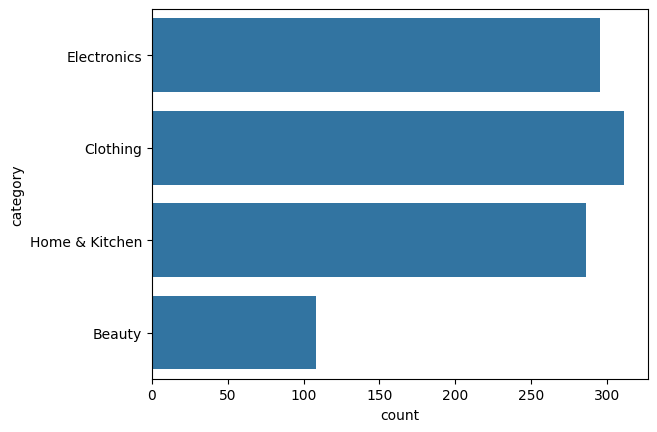

In [255]:
sns.countplot(df_ph_final['category']);

<Axes: xlabel='time_spent', ylabel='Count'>

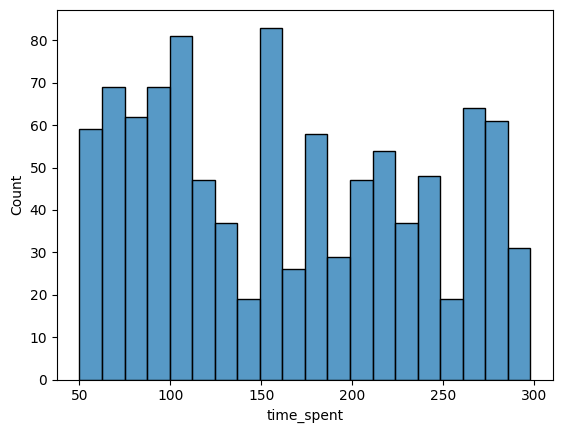

In [256]:
sns.histplot(df_ph_final['time_spent'], bins=20)

<Axes: xlabel='page_views', ylabel='Count'>

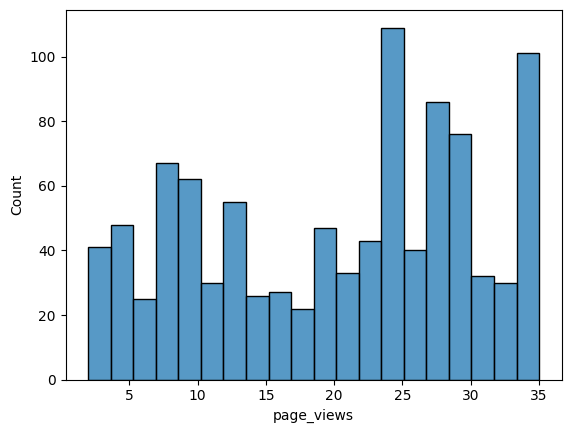

In [257]:
sns.histplot(df_ph_final['page_views'], bins=20)

- distribution of category, time spent and page views variables

In [258]:
df_ph_final.groupby(['customer_id']).agg({
    'price' : ['sum', 'mean'],
    'page_views' : ['sum', 'mean'],
    'time_spent': ['sum', 'mean']
})

price             page_views       time_spent       
               sum        mean        sum  mean        sum   mean
customer_id                                                      
1             6756  519.692308        325  25.0       1560  120.0
2             4098  372.545455        220  20.0        990   90.0
3            11587  551.761905        630  30.0       3150  150.0
4             4542  324.428571        210  15.0       1120   80.0
5             5715  519.545455        242  22.0       1210  110.0
...            ...         ...        ...   ...        ...    ...
96            5888  490.666667        144  12.0       3360  280.0
97             988  197.600000        125  25.0        680  136.0
98            4879  443.545455        242  22.0        572   52.0
99            3547  394.111111        117  13.0       1629  181.0
100           5552  504.727273        319  29.0       1133  103.0

[100 rows x 6 columns]

In [259]:
df_ph_final['purchase_date'].value_counts()

purchase_date
2023-01-02    220
2023-01-03    208
2023-01-01    199
2023-01-05    193
2023-01-04    180
Name: count, dtype: int64

## Data Preprocessing

In [260]:
df_ph_final

customer_id  product_id purchase_date  page_views  time_spent  \
0              1         101    2023-01-01          25         120   
1              3         101    2023-01-01          30         150   
2              3         101    2023-01-03          30         150   
3              4         101    2023-01-02          15          80   
4              5         101    2023-01-05          22         110   
..           ...         ...           ...         ...         ...   
995           21         106    2023-01-05          26         100   
996           17         106    2023-01-01          16         280   
997           43         106    2023-01-05           6         217   
998           91         106    2023-01-01          29         234   
999           90         106    2023-01-04          11         213   

           category  price  ratings  
0       Electronics    500     4.50  
1       Electronics    500     4.50  
2       Electronics    500     4.50  
3       Electronics    500     4.50  
4       Electronics    500     4.50  
..              ...    ...      ...  
995  Home & Kitchen    678     2.74  
996  Home & Kitchen    678     2.74  
997  Home & Kitchen    678     2.74  
998  Home & Kitchen    678     2.74  
999  Home & Kitchen    678     2.74  

[1000 rows x 8 columns]

- the data seems good and no need for data preprocessing

## Model Development
- using KNNwithMeans from scikit surprise
- this model capables to find nearest neighbors and predict the ratings (to indicate user preference)
- our goal is to predict top 5 product with highest ratings related to customers
- my hipothesis is higher ratings mean higher probability customers will buy the products

In [373]:
df_ph_final.head()

customer_id  product_id purchase_date  page_views  time_spent     category  \
0            1         101    2023-01-01          25         120  Electronics   
1            3         101    2023-01-01          30         150  Electronics   
2            3         101    2023-01-03          30         150  Electronics   
3            4         101    2023-01-02          15          80  Electronics   
4            5         101    2023-01-05          22         110  Electronics   

   price  ratings  
0    500      4.5  
1    500      4.5  
2    500      4.5  
3    500      4.5  
4    500      4.5

In [414]:
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(df_ph_final[["customer_id", "product_id", "ratings"]], reader)

- create datasets

In [415]:
sim_options = {
    "name": "cosine",
    "user_based": True,
}
algo = KNNWithMeans(sim_options=sim_options)

- define models

In [416]:
trainset, testset = train_test_split(data, test_size=0.25)
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


- training for the models

In [417]:
rmse(predictions)

RMSE: 0.4993


0.4992596085741228

- using RMSE to evaluate the models and the RMSE seems good around 0.4993

In [418]:
joblib.dump(algo, "KNN_Model.joblib")

['KNN_Model.joblib']

- save model 

### testing

In [420]:
list_predicted = []

for id in df_ph_final['product_id'].unique():
    preds = list(algo.predict(1, id))
    product_id = preds[1]
    product_score = preds[3]

    list_predicted.append((product_id, product_score))

In [425]:
df_ph_final[df_ph_final['customer_id']==1]['product_id'].values

array([101, 105, 120, 110, 102, 115, 103, 103, 122, 114, 114, 124, 121])

In [430]:
top_5_products = sorted(list_predicted, key=lambda x:x[1], reverse=True)[:5]
top_5_products = [product[0] for product in top_5_products]
top_5_products

[105, 121, 118, 114, 101]

- so from the historical data, the models predict that
- the most likely products that the user will buy are 105, 121, 118, 114, 101

## Web Apps Development
- will use gradio and will hosting to huggingface

In [447]:
df_ph_final.to_csv("data_final.csv", index=False)

In [437]:
def product_recommender(customer_id):
    list_predicted = []
    
    for id in df_ph_final['product_id'].unique():
        preds = list(algo.predict(customer_id, id))
        product_id = preds[1]
        product_score = preds[3]
    
        list_predicted.append((product_id, product_score))
        
    top_5_products_raw = sorted(list_predicted, key=lambda x:x[1], reverse=True)[:5]
    top_5_products = [product[0] for product in top_5_products_raw]

    product_1_category = df_ph_final[df_ph_final['product_id']==top_5_products[0]]['category'].values[0]
    product_2_category = df_ph_final[df_ph_final['product_id']==top_5_products[1]]['category'].values[0]
    product_3_category = df_ph_final[df_ph_final['product_id']==top_5_products[2]]['category'].values[0]
    product_4_category = df_ph_final[df_ph_final['product_id']==top_5_products[3]]['category'].values[0]
    product_5_category = df_ph_final[df_ph_final['product_id']==top_5_products[4]]['category'].values[0]

    result_1 = f"Recommendation Product ID {top_5_products[0]} with Category {product_1_category}"
    result_2 = f"Recommendation Product ID {top_5_products[1]} with Category {product_2_category}"
    result_3 = f"Recommendation Product ID {top_5_products[2]} with Category {product_3_category}"
    result_4 = f"Recommendation Product ID {top_5_products[3]} with Category {product_4_category}"
    result_5 = f"Recommendation Product ID {top_5_products[4]} with Category {product_5_category}"

    return result_1, result_2, result_3, result_4, result_5

In [442]:
demo = gr.Interface(
    title="Product Recommendation System",
    description="""This User Interface is Powered by Machine Learning to
                Predict the Top 5 of Product that customer likely to buy in the next purchase.
                All you need is to Input Customer ID and then the Recommendation will be appear.""",
    fn=product_recommender,
    inputs=[
        gr.Number(label="Input Customer ID")
    ],
    outputs=[
        gr.Textbox(label="Recommendation Product 1"),
        gr.Textbox(label="Recommendation Product 2"),
        gr.Textbox(label="Recommendation Product 3"),
        gr.Textbox(label="Recommendation Product 4"),
        gr.Textbox(label="Recommendation Product 5")
    ]
)

In [443]:
demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## Scripts for Deployment in Huggingface

In [445]:
%%writefile requirements.txt
gradio
pandas
numpy
faker
scikit-surprise

Writing requirements.txt


In [449]:
%%writefile app.py
import gradio as gr
import pandas as pd
import joblib

data = pd.read_csv(r"data_final.csv")

def product_recommender(customer_id):
    list_predicted = []
    
    for id in data['product_id'].unique():
        preds = list(algo.predict(customer_id, id))
        product_id = preds[1]
        product_score = preds[3]
    
        list_predicted.append((product_id, product_score))
        
    top_5_products_raw = sorted(list_predicted, key=lambda x:x[1], reverse=True)[:5]
    top_5_products = [product[0] for product in top_5_products_raw]

    product_1_category = data[data['product_id']==top_5_products[0]]['category'].values[0]
    product_2_category = data[data['product_id']==top_5_products[1]]['category'].values[0]
    product_3_category = data[data['product_id']==top_5_products[2]]['category'].values[0]
    product_4_category = data[data['product_id']==top_5_products[3]]['category'].values[0]
    product_5_category = data[data['product_id']==top_5_products[4]]['category'].values[0]

    result_1 = f"Recommendation Product ID {top_5_products[0]} with Category {product_1_category}"
    result_2 = f"Recommendation Product ID {top_5_products[1]} with Category {product_2_category}"
    result_3 = f"Recommendation Product ID {top_5_products[2]} with Category {product_3_category}"
    result_4 = f"Recommendation Product ID {top_5_products[3]} with Category {product_4_category}"
    result_5 = f"Recommendation Product ID {top_5_products[4]} with Category {product_5_category}"

    return result_1, result_2, result_3, result_4, result_5

demo = gr.Interface(
    title="Product Recommendation System",
    description="""This User Interface is Powered by Machine Learning to
                Predict the Top 5 of Product that customer likely to buy in the next purchase.
                All you need is to Input Customer ID and then the Recommendation will be appear.""",
    fn=product_recommender,
    inputs=[
        gr.Number(label="Input Customer ID")
    ],
    outputs=[
        gr.Textbox(label="Recommendation Product 1"),
        gr.Textbox(label="Recommendation Product 2"),
        gr.Textbox(label="Recommendation Product 3"),
        gr.Textbox(label="Recommendation Product 4"),
        gr.Textbox(label="Recommendation Product 5")
    ]
)

if __name__ == "__main__":
    demo.launch()

Writing app.py


- link web apps --> https://huggingface.co/spaces/Adipta/product-recommender
- link repository --> https://huggingface.co/spaces/Adipta/product-recommender/tree/main